# *One image is worth .exe bytes:* Malware Image Classification with CNN

By - Ruşen Birben & Büşra Şahin<br>
*Honorable team members: Anıl Dervişoğlu & Göktürk Dervişoğlu* 

**GOAL**:

The primary goal of this project is to develop a Convolutional Neural Network (CNN) model to classify images of malware into various categories. Accurate classification of malware is crucial for effective threat identification and response in cybersecurity.

**Data Preparation**
- **Dataset Structure**: Malware images are organized into class-specific folders.
- **Data Splitting**: The dataset is divided into training, validation, and test sets to ensure effective learning, avoid overfitting, and evaluate the model on unseen data.

**Dataset Handling**
- **Custom Dataset Class**: Manages loading, preprocessing, and transforming images for the model.
- **Stratified Splitting**: Ensures proportional representation of each class in the validation set for balanced class distribution.

**Model Definition**
- **CNN Architecture**: A Convolutional Neural Network is designed with convolutional layers for feature extraction, pooling layers for dimensionality reduction, and fully connected layers for classification.

**Training**
- **Training Process**: The model is trained on the training dataset by minimizing the loss function and adjusted iteratively. Validation is performed after each epoch to monitor performance and adjust hyperparameters.

**Testing and Evaluation**
- **Inference**: The trained model predicts labels for the test dataset to assess generalization.
- **Evaluation Metrics**: Performance is evaluated using a confusion matrix and accuracy metrics to understand how well the model distinguishes between different malware classes.

**Visualization and Analysis**
- **Example Predictions**: Sample predictions are visualized to qualitatively assess the model’s performance.
- **Loss Curves**: Plots of training and validation losses provide insights into the learning process and help detect overfitting.

**Significance**
- **Identifying Threats**: Accurate classification helps in timely responses and mitigation strategies.
- **Improving Detection Systems**: A robust model can be integrated into security systems to enhance malware detection.
- **Providing Insights**: Performance analysis helps understand the effectiveness of different features and model architectures in malware detection.


## Import Necessary Libraries

Import the required libraries and modules for the malware classification project:

- `os`: For handling directory and file operations.
- `PIL.Image`: For image processing.
- `numpy`: For numerical operations.
- `matplotlib.pyplot` and `seaborn`: For data visualization.
- `tqdm`: For progress bars.
- `sklearn.metrics` and `sklearn.model_selection`: For evaluating and splitting the dataset.
- `torch` and `torchvision`: For deep learning and data transformations.
- `shutil`: For file operations.


In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from typing import List, Tuple, Dict, Optional
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch
import shutil
sns.set()

# Input data files are available in the read-only "../input/" directory
# data is kept as: /kaggle/input/malwareclassificationdatasetimages/big2015_g/[train|test|val]/[class_name]]/

## Define and Prepare the Dataset

This section defines a custom dataset class for loading and transforming malware images, specifies data transformations, initializes the dataset by loading image paths and labels, and splits the dataset into training and validation sets using stratified sampling. Finally, it creates PyTorch data loaders for both training and validation data.

1. **Define the MalwareDataset Class**
    - Create a custom dataset class `MalwareDataset` that inherits from `torch.utils.data.Dataset`.
    - The class has three main methods:
      - `__init__`: Initializes the dataset with image paths, labels, and optional transformations.
      - `__len__`: Returns the total number of samples in the dataset.
      - `__getitem__`: Fetches an image and its corresponding label at a specified index, applies transformations, and converts the label to a numerical value.

2. **Define Transforms for Data Augmentation and Normalization**
    - Specify the transformations to be applied to the images using `transforms.Compose`.
    - These transformations include resizing images to 224x224 pixels, converting them to tensors, and normalizing them using ImageNet mean and standard deviation values.

3. **Initialize the Dataset**
    - Load all image paths and labels from the specified root directory. The dataset is organized such that each class has its own subdirectory.
    - Traverse the directory to gather all image paths and corresponding labels.

4. **Split the Dataset into Training and Validation Sets**
    - Use `StratifiedShuffleSplit` to split the dataset into training and validation sets while maintaining the class distribution in both sets.
    - The `test_size` parameter is set to 1000 to ensure the validation set contains 1000 samples.

5. **Create Data Loaders for Training and Validation Data**
    - Convert the training and validation datasets into PyTorch `DataLoader` instances.
    - The `DataLoader` enables efficient batch processing of the data during model training and validation.


In [2]:
class MalwareDataset(Dataset):
    """
    A custom dataset class for loading and processing malware images.

    This class handles the loading, transformation, and indexing of images and their labels.
    It includes optimizations for faster data loading and processing.

    Attributes:
        image_paths (List[str]): List of file paths to the images.
        labels (List[str]): List of labels corresponding to the images.
        transform (callable, optional): A function/transform to apply to the images.
        class_to_idx (Dict[str, int]): Mapping of class names to class indices.
        preload_images (bool): Whether to preload images into memory.
        images (List[Image.Image]): List of preloaded images (if preload_images is True).
    """

    def __init__(self, image_paths: List[str], labels: List[str], 
                 transform: Optional[callable] = None, preload_images: bool = False):
        """
        Initializes the MalwareDataset class.

        Args:
            image_paths (List[str]): List of file paths to the images.
            labels (List[str]): List of labels corresponding to the images.
            transform (callable, optional): A function/transform to apply to the images.
            preload_images (bool): Whether to preload images into memory for faster access.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.preload_images = preload_images

        # Create a mapping of class names to indices
        unique_labels = sorted(set(self.labels))
        self.class_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

        # Preload images if specified
        self.images = None
        if self.preload_images:
            self.images = [Image.open(path).convert('L') for path in tqdm(self.image_paths, desc='preloading images')]

    def __len__(self) -> int:
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: The number of images in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Retrieves the image and its label at the specified index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (image, label_idx) where image is the transformed image 
                   and label_idx is the index of the label.
        """
        # Load image (from memory if preloaded, otherwise from disk)
        if self.preload_images:
            image = self.images[idx]
        else:
            image = Image.open(self.image_paths[idx]).convert('L')

        # Get label
        label = self.labels[idx]
        label_idx = self.class_to_idx[label]

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label_idx

    @staticmethod
    def load_dataset_from_directory(root_dir: str, transform: Optional[callable] = None, 
                                    preload_images: bool = False) -> 'MalwareDataset':
        """
        Creates a MalwareDataset instance by loading images from a directory structure.

        The directory structure should be:
        root_dir/
            class1/
                image1.png
                image2.png
                ...
            class2/
                image1.png
                image2.png
                ...
            ...

        Args:
            root_dir (str): Path to the root directory containing class subdirectories.
            transform (callable, optional): A function/transform to apply to the images.
            preload_images (bool): Whether to preload images into memory.

        Returns:
            MalwareDataset: An instance of MalwareDataset with loaded data.
        """
        image_paths = []
        labels = []

        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for image_name in os.listdir(class_dir):
                    if image_name.endswith('.png'):
                        image_paths.append(os.path.join(class_dir, image_name))
                        labels.append(class_name)

        return MalwareDataset(image_paths, labels, transform, preload_images)

transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # For grayscale, use single channel normalization
])

# Load the full training dataset
full_train_dataset = MalwareDataset.load_dataset_from_directory(
    '/kaggle/input/malwareclassificationdatasetimages/big2015_g/train', 
    transform, 
    preload_images=True
)

# Calculate sizes for train and validation splits
total_size = len(full_train_dataset)
train_size = int(0.85 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation

# Use random_split to create train and validation datasets
train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Load the test dataset
test_dataset = MalwareDataset.load_dataset_from_directory(
    '/kaggle/input/malwareclassificationdatasetimages/big2015_g/test', 
    transform, 
    preload_images=False
)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 7381
Validation set size: 1303
Test set size: 2176


## Define and Train a Simple CNN Model for Classification

This section defines a simple Convolutional Neural Network (CNN) model for image classification, sets up the training and validation process, and visualizes the training and validation losses over epochs.

1. **Define the SimpleCNN Model Class**
    - Create a custom CNN model class `SimpleCNN` that inherits from `torch.nn.Module`.
    - The class has two main methods:
      - `__init__`: Initializes the model layers including three convolutional layers, max-pooling layers, fully connected layers, ReLU activation, and dropout.
      - `forward`: Defines the forward pass through the network, applying the layers sequentially to the input tensor.

2. **Create the Model, Define the Loss Function, and the Optimizer**
    - Instantiate the `SimpleCNN` model with the number of output classes derived from the training labels.
    - Move the model to the GPU if available.
    - Define the loss function as `CrossEntropyLoss`, which is suitable for classification tasks.
    - Use the SGD optimizer with a learning rate of 0.008 to update the model parameters during training.

3. **Training Loop**
    - Set the number of epochs for training.
    - Initialize lists to store training and validation losses for each epoch.
    - For each epoch:
      - Set the model to training mode using `model.train()`.
      - Initialize a running loss variable to accumulate the training loss.
      - Iterate over batches of training data, move data to the GPU, zero the gradients, perform a forward pass, compute the loss, perform a backward pass, and update the model parameters.
      - Compute the average training loss for the epoch and append it to the `train_losses` list.
      - Set the model to evaluation mode using `model.eval()`.
      - Initialize a running loss variable to accumulate the validation loss.
      - Disable gradient computation and iterate over batches of validation data, move data to the GPU, perform a forward pass, and compute the loss.
      - Compute the average validation loss for the epoch and append it to the `val_losses` list.
      - Print the training and validation losses for each epoch.

4. **Plot Training and Validation Loss**
    - Plot the training and validation losses over epochs to visualize the model's performance.
    - The plot helps to monitor the model's learning progress and detect overfitting or underfitting.


Working on device: cuda
Total trainable parameters: 51,478,025


Epoch 1/20: 100%|██████████| 58/58 [00:11<00:00,  4.87it/s, avg_train_loss=1.4389]


Epoch 1/20, Validation Loss: 0.8335


Epoch 2/20: 100%|██████████| 58/58 [00:11<00:00,  4.95it/s, avg_train_loss=0.7220]


Epoch 2/20, Validation Loss: 0.5798


Epoch 3/20: 100%|██████████| 58/58 [00:11<00:00,  5.12it/s, avg_train_loss=0.5330]


Epoch 3/20, Validation Loss: 0.4656


Epoch 4/20: 100%|██████████| 58/58 [00:12<00:00,  4.81it/s, avg_train_loss=0.4361]


Epoch 4/20, Validation Loss: 0.3711


Epoch 5/20: 100%|██████████| 58/58 [00:11<00:00,  5.12it/s, avg_train_loss=0.3583]


Epoch 5/20, Validation Loss: 0.3531


Epoch 6/20: 100%|██████████| 58/58 [00:11<00:00,  5.25it/s, avg_train_loss=0.3172]


Epoch 6/20, Validation Loss: 0.3334


Epoch 7/20: 100%|██████████| 58/58 [00:11<00:00,  5.23it/s, avg_train_loss=0.2755]


Epoch 7/20, Validation Loss: 0.2709


Epoch 8/20: 100%|██████████| 58/58 [00:11<00:00,  5.14it/s, avg_train_loss=0.2470]


Epoch 8/20, Validation Loss: 0.2609


Epoch 9/20: 100%|██████████| 58/58 [00:11<00:00,  4.94it/s, avg_train_loss=0.2343]


Epoch 9/20, Validation Loss: 0.2451


Epoch 10/20: 100%|██████████| 58/58 [00:11<00:00,  5.19it/s, avg_train_loss=0.2096]


Epoch 10/20, Validation Loss: 0.2227


Epoch 11/20: 100%|██████████| 58/58 [00:11<00:00,  5.00it/s, avg_train_loss=0.2086]


Epoch 11/20, Validation Loss: 0.2466


Epoch 12/20: 100%|██████████| 58/58 [00:11<00:00,  5.15it/s, avg_train_loss=0.1899]


Epoch 12/20, Validation Loss: 0.2181


Epoch 13/20: 100%|██████████| 58/58 [00:11<00:00,  5.22it/s, avg_train_loss=0.1772]


Epoch 13/20, Validation Loss: 0.2165


Epoch 14/20: 100%|██████████| 58/58 [00:11<00:00,  4.94it/s, avg_train_loss=0.1659]


Epoch 14/20, Validation Loss: 0.1914


Epoch 15/20: 100%|██████████| 58/58 [00:11<00:00,  5.15it/s, avg_train_loss=0.1670]


Epoch 15/20, Validation Loss: 0.1986


Epoch 16/20: 100%|██████████| 58/58 [00:11<00:00,  4.91it/s, avg_train_loss=0.1592]


Epoch 16/20, Validation Loss: 0.2161


Epoch 17/20: 100%|██████████| 58/58 [00:11<00:00,  5.18it/s, avg_train_loss=0.1471]


Epoch 17/20, Validation Loss: 0.1963


Epoch 18/20: 100%|██████████| 58/58 [00:11<00:00,  5.20it/s, avg_train_loss=0.1443]


Epoch 18/20, Validation Loss: 0.1950


Epoch 19/20: 100%|██████████| 58/58 [00:11<00:00,  5.17it/s, avg_train_loss=0.1273]


Epoch 19/20, Validation Loss: 0.1917


Epoch 20/20: 100%|██████████| 58/58 [00:11<00:00,  5.22it/s, avg_train_loss=0.1336]


Epoch 20/20, Validation Loss: 0.1806


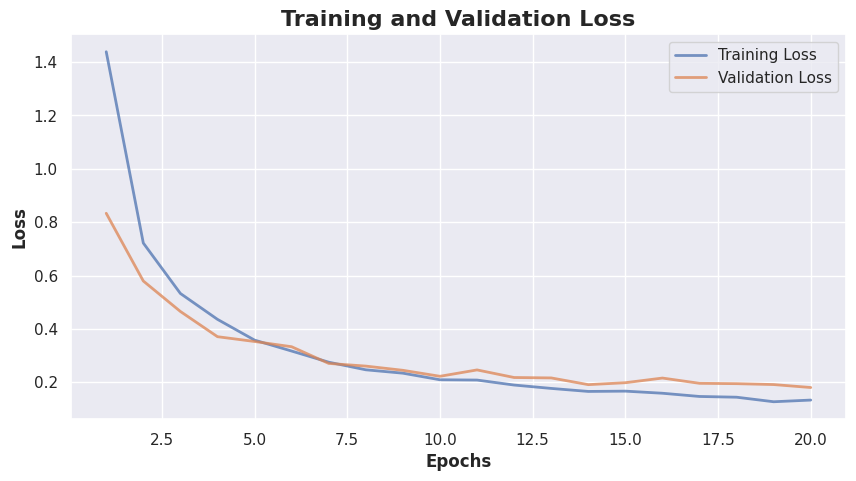

In [5]:
class SimpleCNN(nn.Module):
    """
    A Convolutional Neural Network (CNN) for image classification.

    The model consists of:
    - Three convolutional layers for feature extraction.
    - A max pooling layer to reduce the spatial dimensions.
    - Two fully connected layers for classification.
    - ReLU activations, dropout, and normalization are used throughout the network.
    """

    def __init__(self, num_classes):
        """
        Initializes the SimpleCNN model.

        Args:
            num_classes (int): The number of output classes for classification.
        """
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, num_classes).
        """
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


    
# Adjust the number of workers based on system capabilities
num_workers = min(4, os.cpu_count())

# Create data loaders
train_data_loader = DataLoader(
    train_dataset, 
    batch_size=128, 
    shuffle=True, 
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

val_data_loader = DataLoader(
    val_dataset, 
    batch_size=128, 
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

# Get the number of classes from the full dataset
num_classes = len(full_train_dataset.class_to_idx)

# device and model init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on device: {device}")
model = SimpleCNN(num_classes=num_classes).to(device)

# Print trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

# optmizer and loss function
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.008, momentum=0.8, weight_decay=0.02)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    with tqdm(total=len(train_data_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for i, (images, labels) in enumerate(train_data_loader, 0):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            avg_loss = running_loss / (i + 1)
            pbar.set_postfix({'avg_train_loss': f'{avg_loss:.4f}'})
            pbar.update(1)
    
    epoch_loss = running_loss / len(train_data_loader)
    train_losses.append(epoch_loss)
    
    # Validation
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_data_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
    
    val_epoch_loss = val_running_loss / len(val_data_loader)
    val_losses.append(val_epoch_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}')

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', lw=2, alpha=0.75)
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', lw=2, alpha=0.75)
plt.xlabel('Epochs', fontsize=12, fontweight="bold")
plt.ylabel('Loss', fontsize=12, fontweight="bold")
plt.title('Training and Validation Loss', fontsize=16, fontweight="bold")
plt.legend()
plt.show()

## Model Performance On The Test Dataset

This section initializes the test dataset and DataLoader, performs inference using the trained model, evaluates its performance by generating predictions, and visualizes the results using a confusion matrix and classification accuracy heatmap.

1. **Initialize the Test Dataset**
    - Specify the directory containing the test images.
    - Traverse the directory to collect image file paths and their corresponding labels.
    - Store the collected paths and labels in lists.

2. **Create Dataset and DataLoader for Testing**
    - Instantiate the `MalwareDataset` class with the collected test image paths, labels, and the predefined transformations.
    - Create a `DataLoader` for the test dataset with a batch size of 64 and no shuffling, as the test data order should be preserved.
    - Print the number of samples in the test dataset.

3. **Inference Code**
    - Set the model to evaluation mode using `model.eval()` to disable dropout and batch normalization layers' behavior during inference.
    - Initialize lists to store predictions, true labels, and a few example images.
    - Iterate over batches of test data:
      - Move images and labels to the appropriate device (CPU or GPU).
      - Perform a forward pass to get model outputs.
      - Compute predictions by selecting the class with the highest probability.
      - Store the predictions and true labels.
      - Optionally, save a few examples for visualization.

4. **Visualize Some Examples**
    - Map label indices to class names.
    - Display a few example images with their predicted and ground truth labels to visually inspect the model's performance.

5. **Create and Plot Confusion Matrix**
    - Generate a confusion matrix to evaluate the model's performance across different classes.
    - Plot the confusion matrix using a heatmap to show how often each class was correctly or incorrectly predicted.

6. **Create and Plot Classification Accuracy Heatmap**
    - Compute classification accuracy for each class from the confusion matrix.
    - Plot a bar chart of classification accuracy for each class to visualize how well the model performs on individual classes.



In [6]:
# Initialize the test dataset
test_root_dir = '/kaggle/input/malwareclassificationdatasetimages/big2015_g/test'
test_dataset = MalwareDataset.load_dataset_from_directory(test_root_dir, transform, preload_images=False)

# Create data loader for test dataset
test_loader = DataLoader(
    test_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

print(f"Test set # of data: {len(test_dataset)}")
num_classes = len(test_dataset.class_to_idx)

# Ensure the model is in evaluation mode
model.eval()

# Inference code
all_preds = []
all_labels = []
examples = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Store examples from different classes
        for j in range(len(images)):
            if len(examples) < 3 and preds[j].item() not in [ex[1] for ex in examples]:
                examples.append((images[j].cpu(), preds[j].item(), labels[j].item()))
            if len(examples) == 3:
                break

# Calculate and print the total accuracy
total_correct = np.sum(np.array(all_preds) == np.array(all_labels))
total_samples = len(all_labels)
accuracy = (total_correct / total_samples) * 100
print(f'Total Accuracy On Test Set: {accuracy:.2f}%')

# If you need to map indices back to class names
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}
predicted_labels = [idx_to_class[pred] for pred in all_preds]
true_labels = [idx_to_class[label] for label in all_labels]

Test set # of data: 2176


Testing: 100%|██████████| 68/68 [00:09<00:00,  7.41it/s]

Total Accuracy On Test Set: 96.19%


## Show a few examples

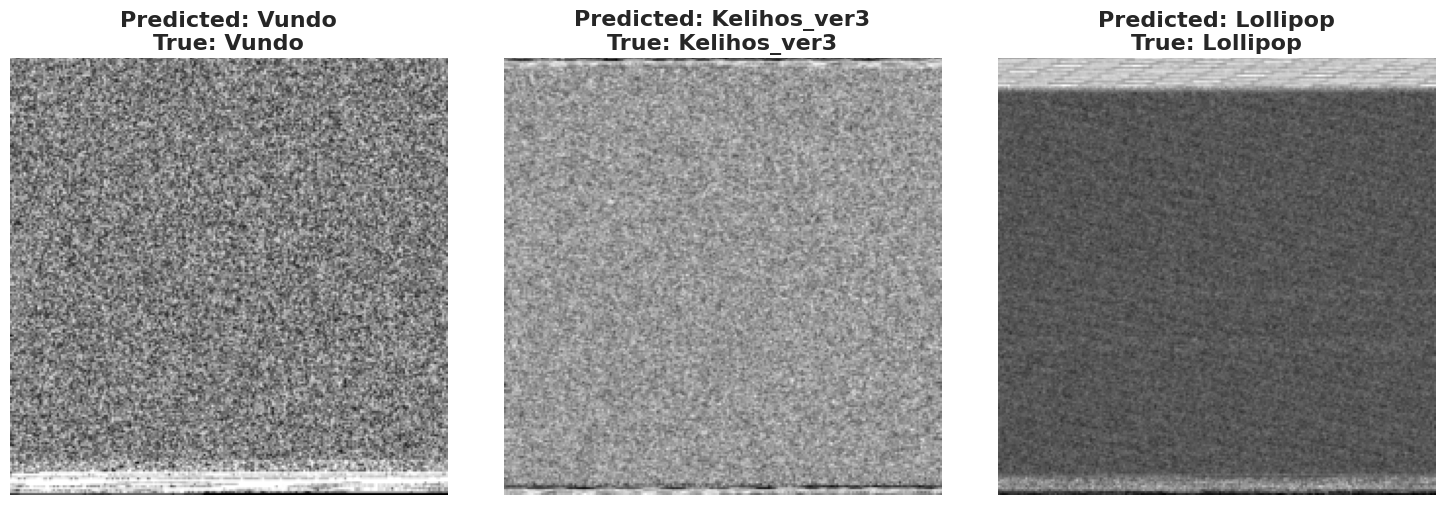

In [7]:
# Visualization function
def imshow(img, ax):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ax.imshow(npimg.squeeze(), cmap='gray')  # Use squeeze() to remove the channel dimension


# Get class names from the full dataset
class_names = list(full_train_dataset.class_to_idx.keys())

# Plot the examples
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (img, pred, label) in enumerate(examples):
    ax = axs[i]
    imshow(img, ax)
    ax.set_title(f"Predicted: {class_names[pred]}\nTrue: {class_names[label]}", fontsize=16, fontweight="bold")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Results

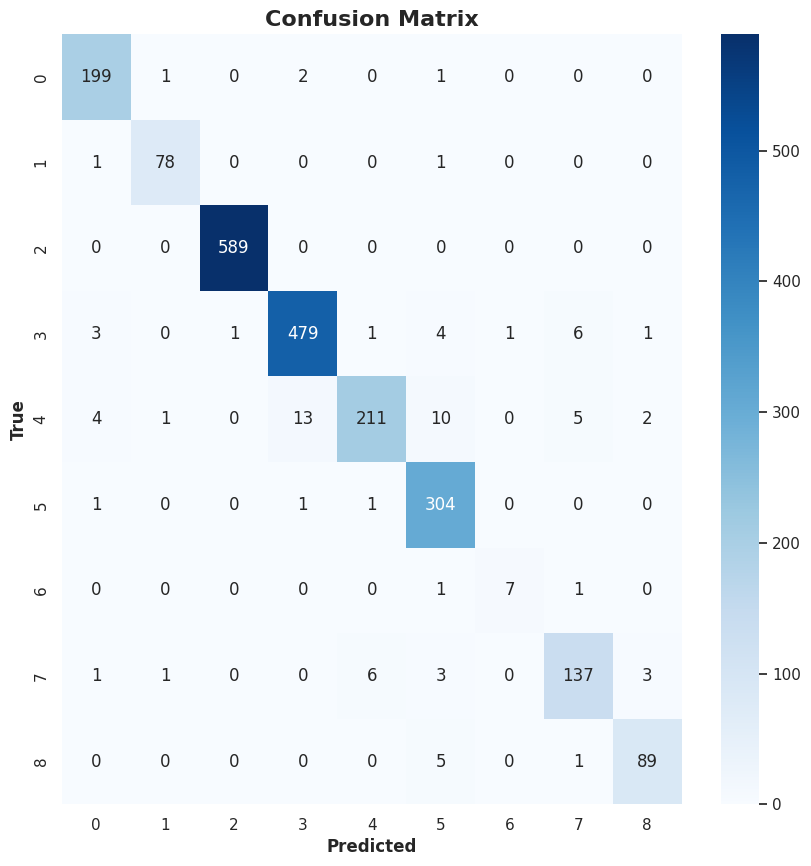

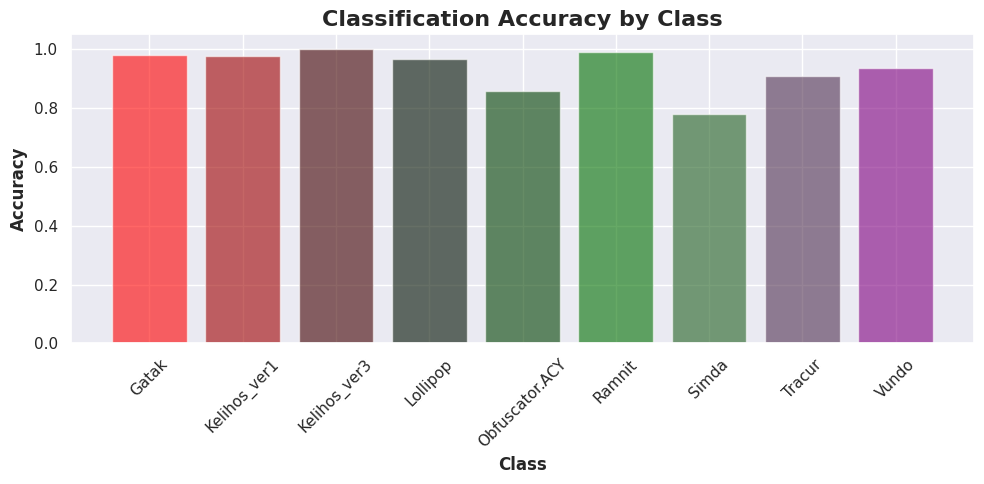

In [8]:
from matplotlib.colors import LinearSegmentedColormap

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # heatmap
plt.xlabel('Predicted', fontsize=12, fontweight="bold")
plt.ylabel('True', fontsize=12, fontweight="bold")
plt.title('Confusion Matrix', fontsize=16, fontweight="bold")
plt.show()

# Create barplot for classification
class_accuracies = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10,5))

colors = ['red', 'black', 'green', "purple"]
n_bins = len(idx_to_class.values())
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
plt.bar(list(idx_to_class.values()), class_accuracies, alpha=0.6, color=cmap(np.linspace(0, 1, n_bins)))
plt.xlabel('Class', fontsize=12, fontweight="bold")
plt.ylabel('Accuracy', fontsize=12, fontweight="bold")
plt.title('Classification Accuracy by Class', fontsize=16, fontweight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.show()

**classification report**

In [9]:
from sklearn.metrics import classification_report
report = classification_report(all_labels, all_preds)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       203
           1       0.96      0.97      0.97        80
           2       1.00      1.00      1.00       589
           3       0.97      0.97      0.97       496
           4       0.96      0.86      0.91       246
           5       0.92      0.99      0.96       307
           6       0.88      0.78      0.82         9
           7       0.91      0.91      0.91       151
           8       0.94      0.94      0.94        95

    accuracy                           0.96      2176
   macro avg       0.94      0.93      0.94      2176
weighted avg       0.96      0.96      0.96      2176

